## Lab 4: Working with 'real' data

### Jennifer Vo, lab partners with William Olsen

## Introduction

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,7)

## Problem 1

In this problem, I will be looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

As with most data, there are 'features.' My lab instructor has helpfully incorporated the meta-data into the data file.

### Part 1
First, I downloaded the data from the course website (gammaray_lab4.h5), and imported it into my working environment. I am using cloud python, so I imported this in the terminal using the command: "wget -O gammaray_lab4.h5 https://canvas.uw.edu/courses/1401649/files/67789336/download?wrap=1"

The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. 

In [73]:
# Import file
hf = h5py.File('gammaray_lab4.h5', 'r')

# Import data into an array
data = np.array(hf.get('data'))
# Let's print the first row as an example
print(data[:,0])
hf.close()

[9.40680016e+08 3.15000000e+02 4.50000000e+01 1.00000000e+01]


Next, I will make a few plots, exploring my data and making sure that I understand it. I will start by making scatter plots of the first 150k data points (rows) of the time vs solar phase and the time vs earth longitude. 

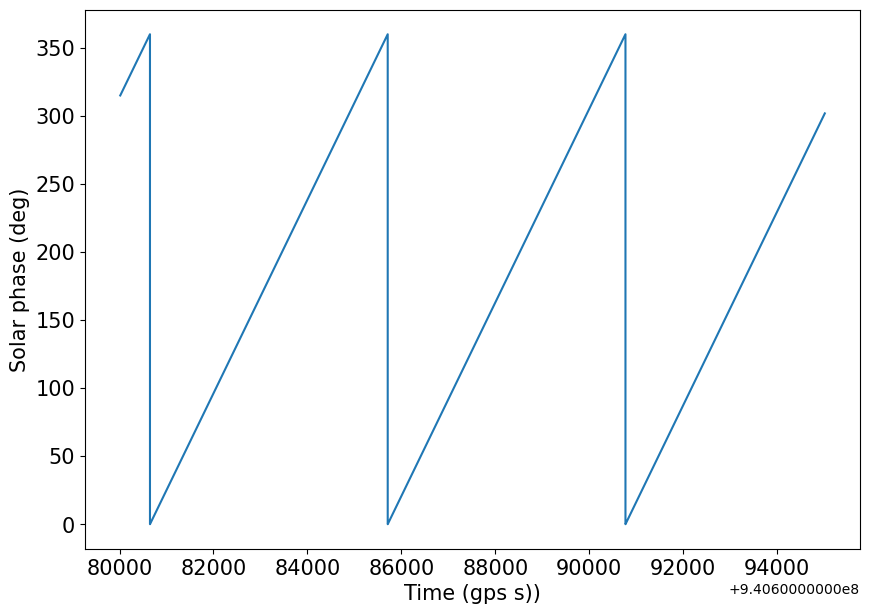

In [55]:
plt.plot(data[0, 0:150000], data[1, 0:150000], '-')
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Solar phase (deg)', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

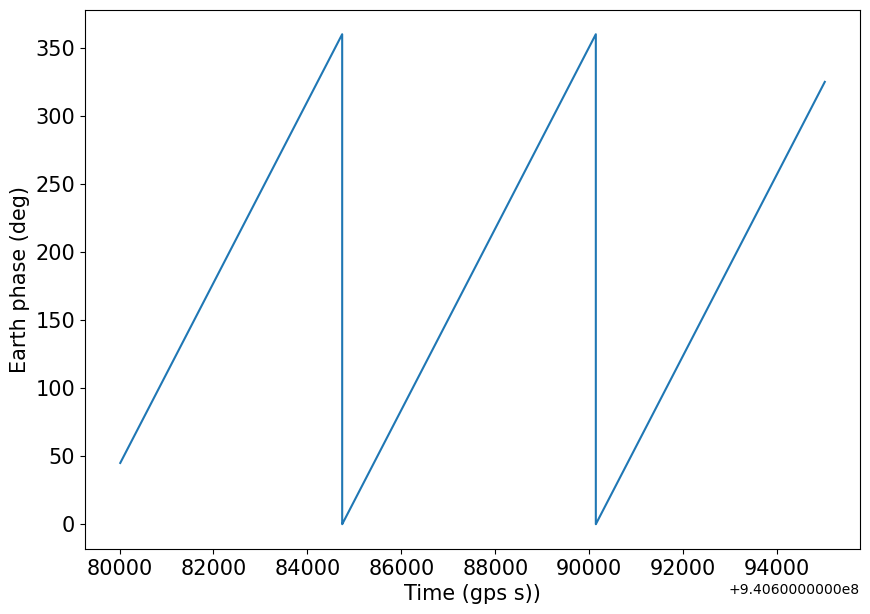

In [56]:
plt.plot(data[0, 0:150000], data[2, 0:150000], '-')
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Earth phase (deg)', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

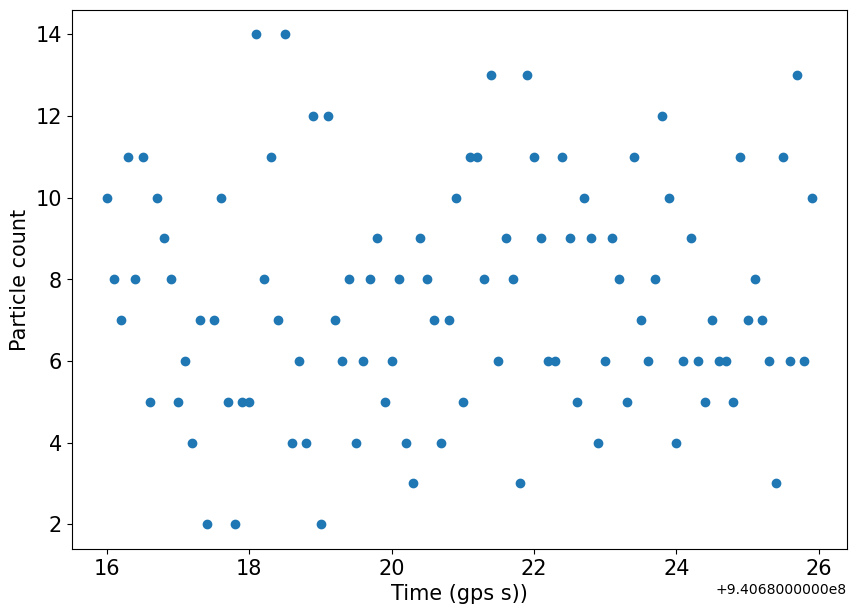

In [71]:
plt.plot(data[0, 0:100], data[3, 0:100], 'o')
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Particle count', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

The time vs particle counts graph appears to have a lot of volatility and did not give much use for plotting the first 150k points, so instead I plotted this with only 100 points of data to clearly show that it is not constant, but rather fluctuates randomly.

From these first 3 scatter plots, I can see that both the Solar phase and Earth phase are positively correlated with time and they both are periodic distributions. I can see that the Solar phase and Earth phase repeat every 360 degrees (or what appears to be every 5150 gps seconds or ~86 minutes) on the time axis. 

The particle counts seem to vary with some distribution. I know that the number of particles I can measure with my data collection must be discrete, so I have the choice between two main distributions for the background: Binomial and Poisson. I know that cosmic ray backgrounds are typically modeled by the Poisson distribution, I will choose to try building the background pdf() with a Poisson distribution.

### Part 2
I'd like to explore how the background changes. Let's try smearing the data, to see how it changes over a larger period of time. The entire dataset is 25 million records; let's just take a look at 300k samples, but only every 3000 points. This should give us around 100 points on a scatter plot for each graph plotted.

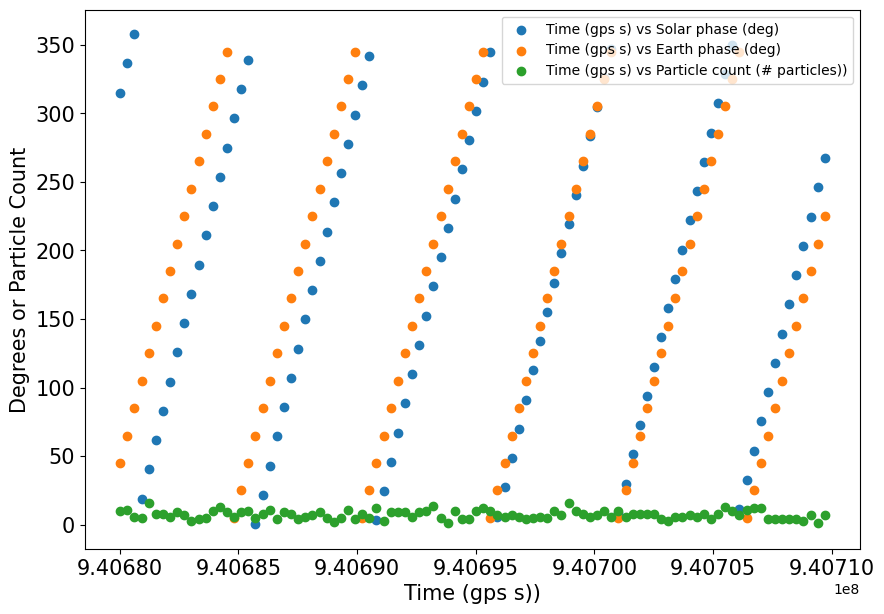

In [113]:
def plot_smear(start,end, steps):
    plt.scatter(data[0, start:end:steps], data[1, start:end:steps], label = 'Time (gps s) vs Solar phase (deg)')
    plt.scatter(data[0, start:end:steps], data[2, start:end:steps], label = 'Time (gps s) vs Earth phase (deg)')
    plt.scatter(data[0, start:end:steps], data[3, start:end:steps], label = 'Time (gps s) vs Particle count (# particles))')
    
plot_smear(0,300000,3000)
plt.legend()
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Degrees or Particle Count', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

For the Solar and Earth phases, they repeat their periodic patterns over this larger range of data points. However, it seems that the phases become closer together over time and switch places; the data begins with the Earth phase leading the Solar phase by about ~75 degrees, then about halfway through the 300k data points, they get so close that they overlap and then the Solar phase leads the Earth phase by about ~25 degrees near the end of the 300k data points graphed here.

In addition, I see some signal contamination. It appears that the highest values of particle counts are measured when both the Solar phase and Earth phase degrees are high. This could indicate that there is a shift in the average of the particle count value over time, in a periodic pattern.

Let's plot the particle count vs time (gps seconds) on a 2d histogram to see if we can determine any more patterns about the data.

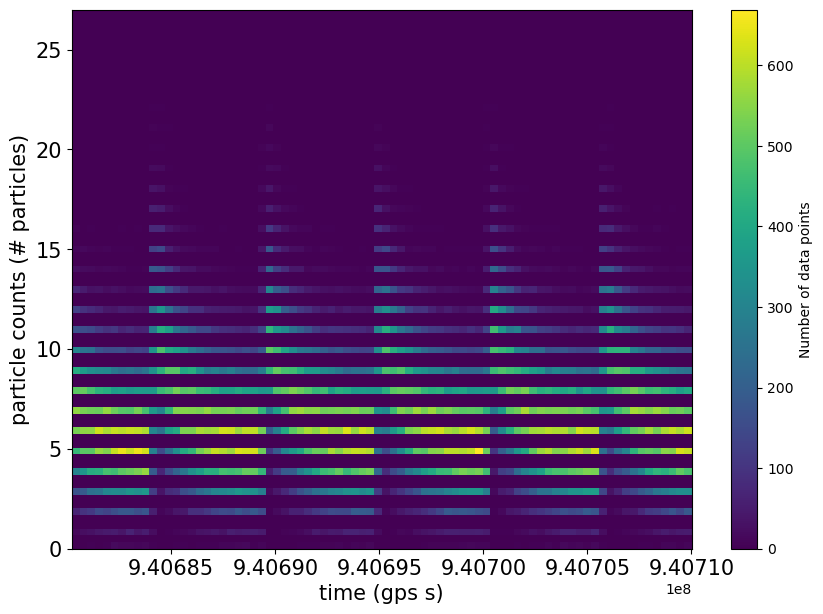

In [118]:
fig, ax = plt.subplots()
h = ax.hist2d(data[0, 2000:300000], data[3, 2000:300000], bins = 80)
fig.colorbar(h[3], ax = ax, label = 'Number of data points')
plt.xlabel('time (gps s)', fontsize = 15)
plt.ylabel('particle counts (# particles)', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

From this 2d histogram, it appears that the average particle count shifts from higher values to lower values in a periodic pattern. This is another sign of contamination of the data from the different Solar phases and Earth phases. The average appears to shift from around 10 to around 5.5 every period. As we established before the period of time seems to be around 5150 gps seconds (86 seconds) to 5400 gps seconds (90 minutes). These are the parameters I will start with to build my background pdf().

##### TO DO: TRY FOLDING THE DATA?

### Part 3
Next, I will try to create a model for the background that includes time dependence, and then explicitly compare my model to the data. 

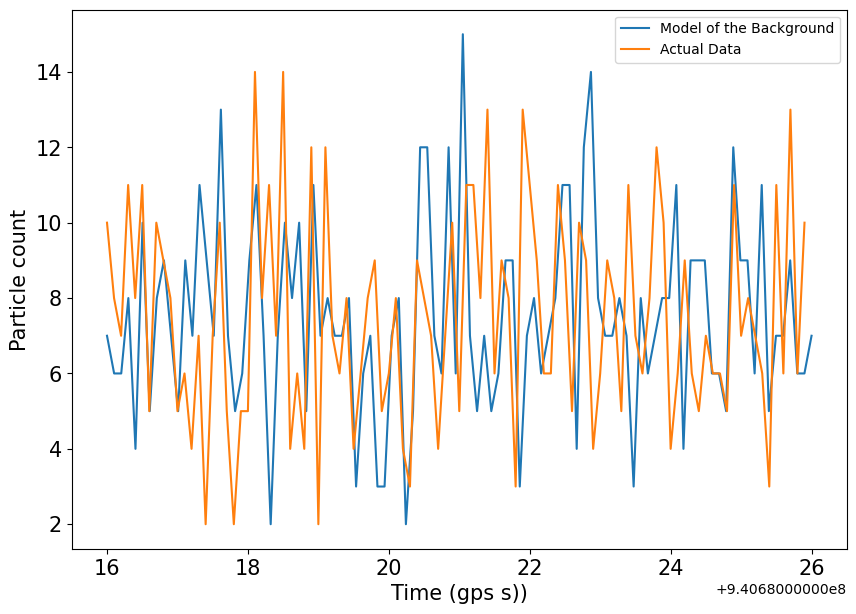

In [135]:
t1 = data[0,0]
t2 = data[0,100]
t_bkg = np.linspace(t1,t2,100)
bkgd_rvs = stats.poisson.rvs(7.5, size = 100)
plt.plot(t_bkgd, bkgd_rvs, '-', label = 'Model of the Background')
plt.plot(data[0, 0:100], data[3, 0:100], '-', label = 'Actual Data')
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Particle count', fontsize=15)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

For the first 100 data points, it seems a Poisson parameter of lambda (average) = 7.5 matches the actual data quite well. 

How do I include time dependence in my model so that this Poisson distribution can accurately capture the entirety of the data, with its changing average particle counts?

In [137]:
# Similar to the code in the homework:
# t = np.linspace(0, np.pi*100, int(1e5))
# N = 10 + np.sin(t)
# bkgd = stats.norm.rvs(size=int(1e5)) * np.sqrt(N) + N

How good is your model of the background?

### Part 4
Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

### Optional Part
While this is simulated data, it is based on a real effect seen by low Earth orbit satellites. Can you identify the cause of the variable background and propose a physical model?